# Prompt 3

In [18]:
import io
import os
import requests
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
infile = '../../Data/circuit_criminal_2019_withDescriptions.csv'
spark = SparkSession \
    .builder \
    .appName("Criminal Expungement") \
    .getOrCreate()
circuit = spark.read.csv(infile, inferSchema=True, header = True)
# circuit.printSchema()

# data wrangling
circuit=circuit\
            .fillna('Unknown',subset='Race')\
            .replace('Other (Includes Not Applicable, Unknown)','Unknown',subset='Race')

# census data 
population = spark.read.csv('../../Data/2019 Virginia Population.csv',header=True)
population = population.drop('Fact Note', 'Value Note for Virginia')
pop_2019 = 8535519
pop_white = 61.2
pop_black = 19.9
pop_hispanic = 9.8
pop_native_amer = 0.5
pop_asian_pacific = 7.0
pop_two_or_more = 3.2 # problem: doesn't exist
# problem: unknown populations are not represented in 

pop = spark.createDataFrame(
    [('White', round(pop_2019*(pop_white/100),2)),  # create your data here, be consistent in the types.
     ('Black', round(pop_2019*(pop_black/100),2)),
     ('Hispanic', round(pop_2019*(pop_hispanic/100),2)),
     ('American Indian Or Alaskan Native', round(pop_2019*(pop_native_amer/100),2)),
     ('Asian Or Pacific Islander', round(pop_2019*(pop_asian_pacific/100),2)),
     ('Two or More Races', round(pop_2019*(pop_two_or_more/100),2)),],
    ["Race", "Population_2019"]  # add your column names here
)
pop.show(truncate=False)
pop.createOrReplaceTempView('pop')

+---------------------------------+---------------+
|Race                             |Population_2019|
+---------------------------------+---------------+
|White                            |5223737.63     |
|Black                            |1698568.28     |
|Hispanic                         |836480.86      |
|American Indian Or Alaskan Native|42677.6        |
|Asian Or Pacific Islander        |597486.33      |
|Two or More Races                |273136.61      |
+---------------------------------+---------------+



In [4]:
circuit.createOrReplaceTempView('df')
df_strat = spark.sql(
'''
SELECT df.code_and_desc, df.Race, count(*) AS RChargeCount, TChargeCount FROM df
JOIN (SELECT code_and_desc AS TCharge, count(*) as TChargeCount FROM df
GROUP BY code_and_desc) T on TCharge = code_and_desc
GROUP BY code_and_desc, Race, TChargeCount
'''
)
df_strat = df_strat.withColumn('Percentage',df_strat['RChargeCount']/df_strat['TChargeCount'])

In [34]:
df_strat_over100 = df_strat.filter(df_strat['TChargeCount'] > 100) # chose code sections 
df_strat_over100 = df_strat_over100.join(pop,on='Race',how='inner')
df_strat_over100 = df_strat_over100.withColumn('# Charges/Population',df_strat_over100['RChargeCount']/df_strat_over100['Population_2019'])
df_strat_over100 = df_strat_over100.sort('# Charges/Population',ascending=False).select(['code_and_desc','Race','# Charges/Population','TChargeCount']).toPandas().rename({
    'code_and_desc':'Code and Most Common Description',
    'TChargeCount':'Total # of Charges'
},axis=1)
df_strat_over100.head(20)

,Code and Most Common Description,Race,# Charges/Population,Total # of Charges
0,"19.2-306, VIOL PROBATION ON FEL OFF",Black,0.004743,20094
1,"19.2-306, VIOL PROBATION ON FEL OFF",White,0.002272,20094
2,"18.2-248, MANUF/ETC CONTROLLED SUBSTANCE",Black,0.001023,4134
3,"18.2-250, POSS.OF CONTROLLED SUBSTANCE",Black,0.001018,6131
4,"19.2-124, BOND APPEAL",Black,0.000953,2951
5,"18.2-250, POSS.OF CONTROLLED SUBSTANCE",White,0.000824,6131
6,"18.2-95, GRAND LARCENY",Black,0.000493,2076
7,"18.2-308.2, NONVIOL FELON POSS GUN W/I 10Y",Black,0.000453,1121
8,"18.2-248, MANUF/ETC CONTROLLED SUBSTANCE",White,0.000445,4134
9,"B.46.2-301, DRIV UNDER REVO/SUSPENSION",Black,0.000423,1183


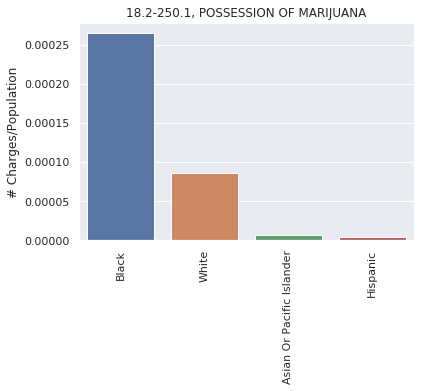

In [44]:
sns.set()
data = df_strat_over100[df_strat_over100['Code and Most Common Description'] == '18.2-250.1, POSSESSION OF MARIJUANA']
sns.barplot(data=data,x='Race',y='# Charges/Population')
plt.xticks(rotation=90);
plt.xlabel('');
plt.title('18.2-250.1, POSSESSION OF MARIJUANA');
plt.show()

In [ ]:
from pyspark.sql.functions import regexp_replace

spark.sql(
'''
SELECT Race, count(*)
FROM df
GROUP BY Race
'''
).show(truncate=False)

In [ ]:
df_strat_over100.filter('Race is null').show(truncate=False)